# CVaR Optimization  
### Gerardo Alcalá
### December 2017
Portfolio optimization, in general, is the process of choosing an allocation of resources in different assets such that this combination is best that any other for a given measure. Conditional Value-at-risk is a coherent risk measure that comes from the distribution of returns of a portfolio, and it is the weighted average of the losses exceeding the Value-at-risk of the portfolio.  
  
In this exercise we are going to perform optimization on a set of assets to invest in a portfolio that would minimize this Conditional Value-at-risk, as proposed in the following papers:
> Rockafellar, R.T. and Uryasev, S., 2000. Optimization of conditional value-at-risk. Journal of risk, 2, pp.21-42.
> Rockafellar, R.T. and Uryasev, S., 2002. Conditional value-at-risk for general loss distributions. Journal of banking & finance, 26(7), pp.1443-1471.

This model is an application of stochastic programming to solve optimization problems under uncertainty.

### Packages

We are going to need the following functions and packages from Python.

In [1]:
from __future__ import division 
from pyomo.environ import *
infinity = float('inf')
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyomo.opt import SolverFactory
opt = SolverFactory("glpk")

### The Data

The data is available upon request, yet it is easy to replicate. Our data consists of the prices from 9 stocks downloaded from Yahoo Finance from January 1st, 2012 to December 31st, 2016. The csv file has stored the columns Date, Open, High, Low, Close, Adj Close, Volume and ticker for the companies Apple, Amazon, Citigroup, CVS Health Corporation, Ford, Facebook, Google, JP Morgan and Exxon Mobil.

In [20]:
stocks = pd.read_csv('C:/Users/galcala/stock_data.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'])
print(stocks.info())
stocks.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11227 entries, 0 to 11226
Data columns (total 8 columns):
Date         11227 non-null datetime64[ns]
Open         11227 non-null float64
High         11227 non-null float64
Low          11227 non-null float64
Close        11227 non-null float64
Adj Close    11227 non-null float64
Volume       11227 non-null int64
ticker       11227 non-null object
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 701.8+ KB
None


,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2012-01-03,324.360352,331.916199,324.077179,330.555054,330.555054,7400800,GOOG
1,2012-01-04,330.366272,332.959412,328.175537,331.980774,331.980774,5765200,GOOG
2,2012-01-05,328.925659,329.839722,325.994720,327.375732,327.375732,6608400,GOOG
3,2012-01-06,327.445282,327.867523,322.795532,322.909790,322.909790,5420700,GOOG
4,2012-01-09,321.161163,321.409546,308.607819,309.218842,309.218842,11720900,GOOG


Our first step is to transform the dataset from long to wide format, and we are only keeping the Adj. Close column, as it represents the price adjusted for dividends and splits. We are going to _clean_ our data very poorly, please, refrain from just dropping missing values. The reason we are doing this in this example is because we are more concerned on the optimization, but remember always: **Garbage IN, Garbage OUT**

In [21]:
serie_stocks = stocks.pivot(index='Date', columns='ticker', values='Adj Close')
serie_stocks=serie_stocks.dropna()
pd.concat([serie_stocks.head(),serie_stocks.tail()])

ticker,AAPL,AMZN,C,CVS,F,FB,GOOG,JPM,XOM
Date,,,,,,,,,
2012-05-18,67.921494,213.850006,25.269936,40.429947,7.953341,38.230000,298.260101,28.877260,68.499329
2012-05-21,71.878601,218.110001,25.503115,40.839432,8.104302,34.029999,305.070801,28.032232,68.978592
2012-05-22,71.326653,215.330002,26.154053,40.894028,8.096357,31.000000,298.458801,29.325623,68.902931
2012-05-23,73.067009,217.279999,26.377504,40.757545,8.271155,32.000000,302.760834,29.541199,68.978592
2012-05-24,72.395958,215.240005,25.901445,41.103317,8.414173,33.029999,299.879578,29.291142,69.457825
2016-12-23,114.675896,760.590027,60.115902,77.149139,11.799386,117.269997,789.909973,85.108040,87.383606
2016-12-27,115.404190,771.400024,60.214474,77.295364,11.733097,118.010002,791.549988,85.186241,87.422142
2016-12-28,114.912109,772.130005,59.179520,77.051659,11.600519,116.919998,785.049988,84.570305,86.988647
2016-12-29,114.882584,765.150024,58.528980,77.012657,11.581578,116.349998,782.789978,83.973915,87.036804


From our previous dataset we can compute our daily returns. To visualize our stocks, we can also plot their risk measured by the standard deviation (annualized) to their mean returns (annualized).

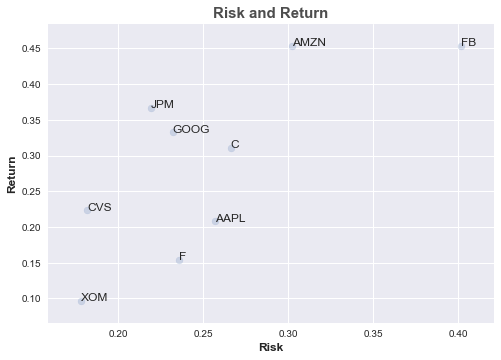

In [22]:
ret30dias = serie_stocks / serie_stocks.shift(1) - 1
ret30dias=ret30dias.dropna()
retornos = np.mean(ret30dias,axis=0)*360
riesgo = ret30dias.apply(np.std,axis=0)*sqrt(252)
plt.scatter(riesgo, retornos,alpha =0.2)
plt.title("Risk and Return", weight="bold", size=15, color = "0.3")
plt.xlabel("Risk", weight="bold", size=12)
plt.ylabel("Return", weight="bold", size=12)
for i, txt in enumerate(riesgo.index):
    plt.annotate(txt, (riesgo[i],retornos[i]))

plt.show()

### The Model

The data is available upon request, yet it is easy to replicate. Our data consists of the prices from 9 stocks downloaded from Yahoo Finance from January 1st, 2012 to December 31st, 2016. The csv file has stored the columns Date, Open, High, Low, Close, Adj Close, Volume and ticker for the companies Apple, Amazon, Citigroup, CVS Health Corporation, Ford, Facebook, Google, JP Morgan and Exxon Mobil.

\begin{align*}
\underset{x_{ij}}{\min} & \quad \alpha + \frac{1}{q(1-\beta)} \sum_{k=1}^{q}u_{k}\\
\text{s.t.:}&\\
  & u_{k} \geq 0 \quad \forall k\\
  & \alpha + x^{T}y_{k} +  u_{k} \geq 0 \quad \forall k \\
  & \sum_{i=1}^{N} x_{i} = 1 \quad 
\end{align*}


where $u_k$ are ancillary variables that help us find the optimal weights $x_i$ for each asset $i$, $q$ es a parameter that represents the number of escenarios we are simulating with probability $\frac{1}{q}$. For each of these scenarios we obtain our vector of realized returns $y_k$. The beauty of this implementation is that $\alpha$ is our Value-at-Risk.

### The implementation

We are going to use Pyomo to solve our problem. Pyomo is an open-source optimization language based in Python. The following lines are used to define our simulated vector $y_k$ for each $k$. the number of simulations is $\text{n_sc}$.

In [95]:
n_sc = 1500
assets=len(retornos)
muestra = np.random.choice(len(ret30dias), size=n_sc, replace=True, p=None)
simulaciones = np.array(ret30dias.iloc[muestra,])
beta = 0.95

In [96]:
model = ConcreteModel()
    
model.escenarios = RangeSet(1,n_sc)
model.N = RangeSet(1,assets)
    
model.weights = Var(model.N,within=NonNegativeReals)
model.alpha = Var()
model.u = Var(model.escenarios,within=NonNegativeReals)
    
def _Obj(model):
    return model.alpha + (1/(1-beta))*sum(model.u[k]*(1/n_sc) for k in model.escenarios)
model.Obj = Objective(rule=_Obj, sense = minimize)
    
def _nonNegative(model,escenario):
    return (model.alpha + model.u[escenario] + sum(model.weights[i]*simulaciones[escenario-1,i-1] for i in model.N)) >= 0
model.nonNegative = Constraint(model.escenarios,rule=_nonNegative)

def _fullyInvested(model):
    return sum(model.weights[activos] for activos in model.N) == 1
model.fullyInvested = Constraint(rule=_fullyInvested)


The last lines define an Optimization Model like described above. It is worth noticing that we have used an empirical joint distribution of asset returns: the observed returns in our dataset. What we have done here is take a sample, with replacement, of these results.

Let us print our solution for our model:

In [56]:
results = opt.solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.0184610487896888
  Upper bound: 0.0184610487896888
  Number of objectives: 1
  Number of constraints: 1502
  Number of variables: 1511
  Number of nonzeros: 16430
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.18443632125854492
# ----------------------------------------------------------
#   Solution Information
# -

The output above is the status of the solver. We have found an optimal solution. Let's see what it tells us:

In [76]:
pesos = []

print("Optimal Weights: ")
for i,p in enumerate(model.weights):
    print(riesgo.index[i],":",round(model.weights[p].value*10000)/100,"%")
    pesos.append(model.weights[p].value)
print("-----------------------------")   
print("")  
print("VaR (alpha) from our model: ")  
for p in model.alpha:
    print("-",np.round(model.alpha[p].value*10000)/100,"%")
    var = model.alpha[p].value

Optimal Weights: 
AAPL : 6.15 %
AMZN : 1.0 %
C : 0.0 %
CVS : 20.28 %
F : 1.96 %
FB : 0.0 %
GOOG : 21.68 %
JPM : 2.71 %
XOM : 46.23 %
-----------------------------

VaR (alpha) from our model: 
- 1.32 %


Our optimization results in a portfolio with no allocation in Citi and Facebook and a small participation in Amazon, Ford and JP Morgan. Let us now contrast the distribution of our portfolio using these weights vs an equally weighted portfolio.

Value at Risk 95% for optimal weights
-1.3 %
Conditional Value at Risk:
-1.84 %


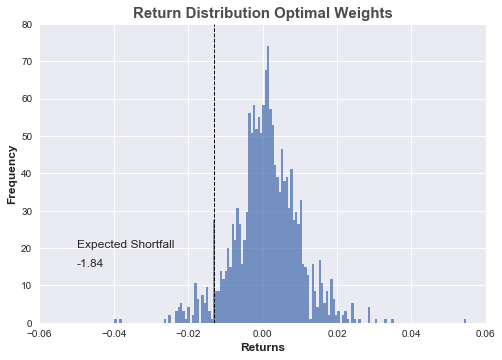


Value at Risk 95% for equally weighted
-1.45 %
Conditional Value at Risk:
-2.13 %


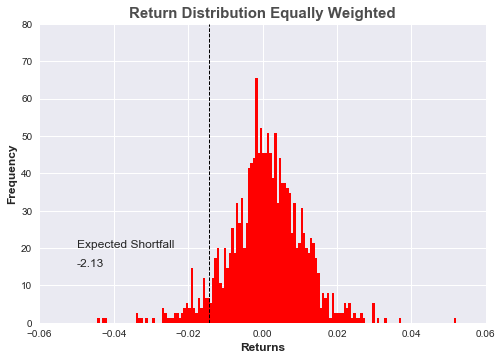

In [94]:
pesos = np.array(pesos)
backtest = pd.Series(ret30dias.dot(pesos))
equal = pd.Series(ret30dias.dot(np.ones(assets)/assets))



valores = backtest.sort_values().reset_index()
valores.columns = ['indice','retorno']
print("Value at Risk 95% for optimal weights")
print(round(valores.iloc[75,1]*10000)/100,"%")
print("Conditional Value at Risk:")
print(round(np.mean(valores.iloc[:75,1])*10000)/100,"%")
pd.Series(simulaciones.dot(pesos)).hist(bins=150,normed=1, alpha=0.75)
plt.title("Return Distribution Optimal Weights", weight="bold", size=15, color = "0.3")
plt.xlabel("Returns", weight="bold", size=12)
plt.ylabel("Frequency", weight="bold", size=12)
plt.xlim([-.06,0.06])
plt.ylim([0,80])
plt.axvline(x=valores.iloc[75,1],color="black",linestyle="dashed",linewidth=1)
plt.annotate("Expected Shortfall", ('-.05',20))
plt.annotate(round(np.mean(valores.iloc[:75,1])*10000)/100, ('-.05',15))
plt.show()
print("")
valores = equal.sort_values().reset_index()
valores.columns = ['indice','retorno']
print("Value at Risk 95% for equally weighted")
print(round(valores.iloc[75,1]*10000)/100,"%")
print("Conditional Value at Risk:")
print(round(np.mean(valores.iloc[:75,1])*10000)/100,"%")

pd.Series(equal).hist(bins=150, color="red",normed=1)
plt.title("Return Distribution Equally Weighted", weight="bold", size=15, color = "0.3")
plt.xlabel("Returns", weight="bold", size=12)
plt.ylabel("Frequency", weight="bold", size=12)
plt.xlim([-.06,0.06])
plt.ylim([0,80])
plt.axvline(x=valores.iloc[75,1],linestyle="dashed",linewidth=1,color = "black")
plt.annotate("Expected Shortfall", ('-.05',20))
plt.annotate(round(np.mean(valores.iloc[:75,1])*10000)/100, ('-.05',15))
plt.show()

As expected, we find a portfolio which has a distribution with lighter left tail. This approach is attractive to study as VaR and CVaR are metrics which most portfolio managers use to monitor their risk exposure.

## Final Remarks

We can perform a better model if we obtain more data. Also, from a risk perspective, maybe over-sampling periods of high volatility would help to study portfolio compositions with higher resilience in such periods of time. I would always recommend to clean the data properly, and keeping an "out of sample" timeframe to analyze ex-post distributions is advised.